# Analysis of Illusory Pitch Study

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pylab as plt

# Excluded participants
EXCLUDED = [21]
SCORES_DATAFILE = '../data/scores.csv'
FITS_DATAFILE = '../data/fits.csv'
FIGURE_PATH = './figures/'

In [2]:
THEME = 'light'

# Set line widths and marker sizes
lw = 1.5
capsize = 3
msize = 7

# Set colors for light and dark versions of figures
if THEME == 'dark':
    background_color = '#151619'
    text_color = 'w'
    color1 = '#90E6E2'
    color2 = '#FAB2B9'
elif THEME == 'light':
    background_color = 'w'
    text_color = 'k'
    color1 = '#512D6D'
    color2 = '#F8485E'
else:
    raise ValueError('Theme not recognized - must be one of "light" or "dark".')

plt.rcParams.update({
    # BACKGROUND
    'figure.facecolor': background_color,
    'axes.facecolor': background_color,
    'savefig.facecolor': background_color,

    # TEXT
    'text.color': text_color,
    'axes.labelcolor': text_color,
    'xtick.color': text_color,
    'ytick.color': text_color,
    'figure.titlesize': 20,  # fontsize of the figure title
    'axes.titlesize': 20,
    'axes.labelsize': 16,  # fontsize of the x and y labels
    'xtick.labelsize': 12,  # fontsize of the tick labels
    'ytick.labelsize': 12,  # fontsize of the tick labels
    'legend.fontsize': 12,  # legend fontsize
    'legend.title_fontsize': 14,  # legend title size
    'font.size': 12,  # text size

    # FIGURE STYLE
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.edgecolor': text_color,
    'axes.grid': False,
    'ytick.left': True,
    'xtick.bottom': True
})

### Load and preprocess data

In [12]:
scores = pd.read_csv(SCORES_DATAFILE)
print('Count: %i' % len(np.unique(scores.subject)))
print('v1.1 Count: %i' % len(np.unique(scores.subject[scores.version >= 1.1])))
scores = scores[scores.version >= 1.1]
scores = scores[~np.isin(scores.subject, EXCLUDED)]

# Load linear fits of bias
fits = pd.read_csv(FITS_DATAFILE)
fits = fits[fits.version >= 1.1]
fits = fits[~np.isin(fits.subject, EXCLUDED)]

# Loftus & Masson (1994) method of plotting within-subject effects (for C and dprime)
subj_means = scores.groupby(['subject']).mean().reset_index()
grand_mean = subj_means.mean()
within_scores = scores.copy()
for i, subj in enumerate(subj_means.subject):
    within_scores.loc[within_scores.subject == subj, 'dprime'] -= subj_means.dprime[i] - grand_mean.dprime
    within_scores.loc[within_scores.subject == subj, 'C'] -= subj_means.C[i] - grand_mean.C

# Stagger the x-axis values so error bars will be easier to read
within_scores.loc[within_scores.shift_size == 1.0, 'interval'] -= 2
within_scores.loc[within_scores.shift_size == 0.5, 'interval'] += 2

Count: 41
v1.1 Count: 28


### Effect of Difficulty on Sensitivity

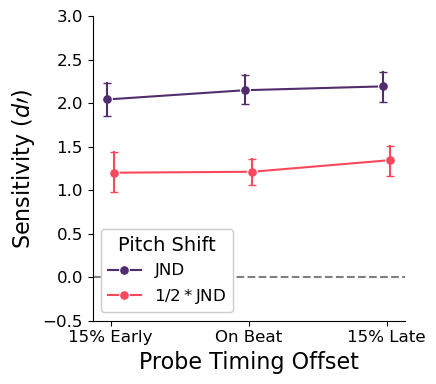

In [4]:
# Plot average d' per condition
sns.lineplot(x='interval', y='dprime', hue='shift_size', data=within_scores,
             hue_order=[1.0, 0.5], palette=[color1, color2],
             marker='o', markersize=msize, ls='-', lw=lw,
             err_style='bars', err_kws={'capsize': capsize})

# Sylize subplot
plt.axhline(0, ls='--', c='k', alpha=.5)
plt.legend(['JND', '$1/2*$JND'], title='Pitch Shift', framealpha=1, loc='lower left')
plt.ylabel('Sensitivity ($d\prime$)')
plt.xlabel('Probe Timing Offset')
plt.xticks([425, 500, 575], ['15% Early', 'On Beat', '15% Late'])
plt.ylim(-0.5, 3)

# Stylize figure and save
plt.gcf().set_size_inches(4.5, 4)
plt.tight_layout()
plt.gcf().savefig('figures/dprime2.svg')

### Effect of Timing and Difficulty on Bias

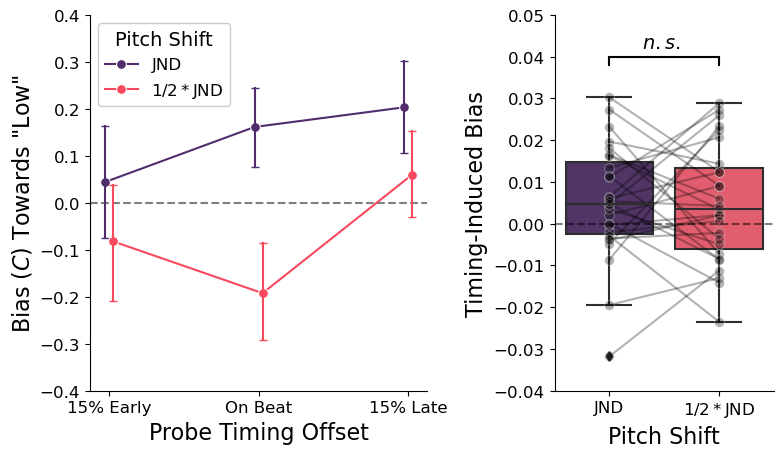

In [17]:
grid = plt.GridSpec(1, 2, width_ratios=[2, 1.3])

###
# C
###

plt.subplot(grid[0])

# Plot average C per condition
sns.lineplot(x='interval', y='C', hue='shift_size', data=within_scores,
             hue_order=[1.0, 0.5], palette=[color1, color2],
             marker='o', markersize=msize, ls='-', lw=lw,
             err_style='bars', err_kws={'capsize': capsize})

# Stylize subplot
plt.axhline(0, ls='--', c='k', alpha=.5, zorder=1)
plt.legend(['JND', '$1/2*$JND'], title='Pitch Shift', framealpha=1, loc='upper left')
plt.ylabel('Bias ($C$) Towards "Low"')
plt.xlabel('Probe Timing Offset')
plt.xticks([425, 500, 575], ['15% Early', 'On Beat', '15% Late'])
plt.ylim(-.4, .4)

###
# Timing-Induced Bias
###

plt.subplot(grid[1])

sns.boxplot(x='shift_size', y='C_slope', data=fits[fits.shift_size != 'pooled'], order=['1', '0.5'], palette=[color1, color2])
shift_map = {'1': 0, '0.5': 1}
for s in fits.subject.unique():
    sfits = fits[(fits.subject == s) & (fits.shift_size != 'pooled')]
    sns.lineplot(x=[shift_map[x] for x in sfits.shift_size], y='C_slope', data=sfits,
                 color=text_color, alpha=.3, marker='o', ms=msize, lw=lw)
plt.axhline(0, ls='--', alpha=.5, color=text_color)

plt.text(.3, .042, '$n.s.$', fontsize=14)
plt.plot([0, 1], [.04, .04], c=text_color)
plt.plot([0, 0], [.038, .04], c=text_color)
plt.plot([1, 1], [.038, .04], c=text_color)

plt.xlabel('Pitch Shift')
plt.ylabel('Timing-Induced Bias')
plt.xticks([0, 1], ['JND', '$1/2*$JND'])
plt.ylim(-.04, .05)

# Stylize figure and save
plt.gcf().set_size_inches(8, 4.75)
plt.tight_layout()
plt.gcf().savefig('figures/bias2.svg', dpi=150)

### Plot correlation between JND and timing-induced bias

In [6]:
# Load linear fits of bias at the person's JND
fits = pd.read_csv(FITS_DATAFILE)
fits = fits[fits.version >= 1.1]
fits = fits[~np.isin(fits.subject, EXCLUDED)]
fits = fits[fits.shift_size == 'pooled']

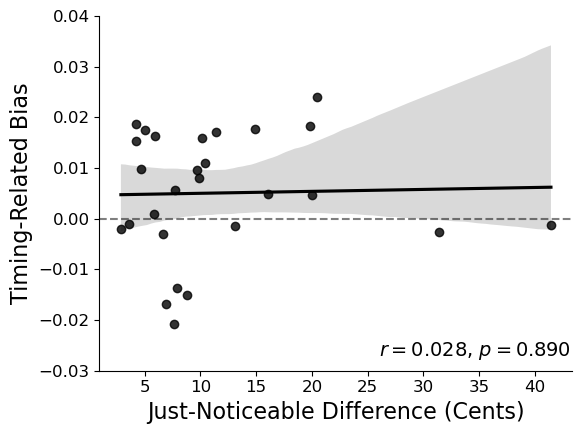

In [7]:
sns.regplot(x='jnd', y='C_slope', data=fits, color=text_color)
plt.axhline(y=0, linestyle='--', color=text_color, alpha=.5)
r, p = stats.pearsonr(fits.jnd, fits.C_slope)
plt.text(26, -.027, '$r=%.03f$, $p=%.03f$' % (r, p), fontsize=14)
plt.xlabel('Just-Noticeable Difference (Cents)')
plt.ylabel('Timing-Related Bias')
plt.ylim(-.03, .04)
plt.gcf().set_size_inches(6, 4.5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'jnd_correlation.svg')